In [10]:
import os
import pytorch_lightning as pl
import torch 
from torch import nn
from torch import utils

from torchaudio import datasets, transforms
from torchvision import models

from transformers import T5Tokenizer, T5ForConditionalGeneration
import nltk
import numpy as np
import string
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from tqdm import tqdm


In [11]:
dataset = datasets.LIBRISPEECH(
                            root="./",
                            url="dev-clean",
                            folder_in_archive="LibriSpeech",
                            download=False
                            )

In [12]:
dataset_train = datasets.LIBRISPEECH(
                                     root="/mnt/f/train-clean-360",
                                     url="train-clean-360",
                                     folder_in_archive="LibriSpeech",
                                     download=False
                                    )

dataset_test = datasets.LIBRISPEECH(
                                    root="/mnt/f/test-clean",
                                    url="test-clean",
                                    folder_in_archive="LibriSpeech",
                                    download=False
                                    )

print(f"Tamanho do conjunto de treino: {len(dataset_train)}")
print(f"Tamanho do conjunto de teste: {len(dataset_test)}")

Tamanho do conjunto de treino: 104014
Tamanho do conjunto de teste: 2620


In [6]:
dataset_train[3]

(tensor([[ 0.0017,  0.0007, -0.0009,  ...,  0.0005,  0.0005,  0.0004]]),
 16000,
 "BUT HE WAS SO SLY AND CAUTIOUS THAT NO ONE HAD EVER CAUGHT HIM IN THE ACT OF STEALING ALTHOUGH A GOOD MANY THINGS HAD BEEN MISSED AFTER THEY HAD FALLEN INTO THE OLD MAN'S WAY BARNEY HAD ONE SON NAMED TOM",
 100,
 121669,
 3)

In [7]:
wav_lengths = []
for value in tqdm(dataset_train):
    wav_lengths.append(value[0].shape[1])

KeyboardInterrupt: 

In [10]:
len(wav_lengths)

31900

In [9]:
max(wav_lengths)

475760

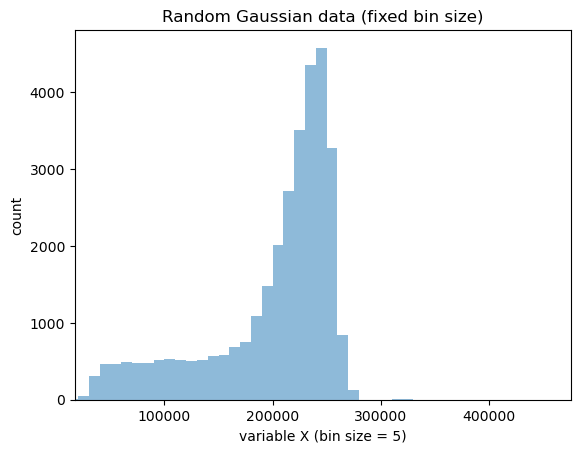

In [11]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = np.array(wav_lengths)

# fixed bin size
bins = np.arange(0, 600000, 10000) # fixed bin size

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()


In [13]:
encoder = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1).features
decoder = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")
transform = transforms.MelSpectrogram(16000, n_fft=1252, n_mels=128)


In [14]:
class TokenizedDataset(utils.data.Dataset):
    def __init__(self, raw_dataset, tokenizer, max_len=320000):
        self.raw_dataset = raw_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.raw_dataset)
    
    def __getitem__(self, idx):
        data = self.raw_dataset[idx]
        x = data[0]
        y = data[2]

        y = self.tokenizer.encode_plus(
                                        text=y,  # the sentence to be encoded
                                        add_special_tokens=True,  # Add [CLS] and [SEP]
                                        max_length=512,  # maximum length of a sentence
                                        padding="max_length",  # Add [PAD]s
                                        return_tensors='pt',  # ask the function to return PyTorch tensors
                                        truncation=True,
                                    )

        if x.shape[1] < self.max_len:
            pad_x = torch.zeros((x.shape[0], self.max_len))
            pad_x[:, :x.size(1)] = x
            x = pad_x
        else:
            x = x[:,0:(self.max_len)]

        
        #return x,y["input_ids"], y["attention_mask"]
        return x,y["input_ids"].squeeze(), y["attention_mask"].squeeze()

mydataset = TokenizedDataset(dataset, tokenizer)
mydataset[0][0].shape

torch.Size([1, 320000])

In [6]:
mydataset = TokenizedDataset(dataset, tokenizer)

train_set, val_set, test_set = utils.data.random_split(mydataset, [0.6, 0.2, 0.2])

train_loader = utils.data.DataLoader(train_set, batch_size=4, num_workers=os.cpu_count())
val_loader = utils.data.DataLoader(val_set, batch_size=4, num_workers=os.cpu_count())
test_set = utils.data.DataLoader(test_set, batch_size=4, num_workers=os.cpu_count())

#train_loader = utils.data.DataLoader(train_set, batch_size=2)
#val_loader = utils.data.DataLoader(val_set, batch_size=2)
#test_set = utils.data.DataLoader(test_set, batch_size=2)


In [15]:
mydataset_train = TokenizedDataset(dataset_train, tokenizer)
mydataset_test = TokenizedDataset(dataset_test, tokenizer)


train_set, val_set = utils.data.random_split(mydataset_train, [0.99, 0.01], generator=torch.Generator().manual_seed(42))

train_loader = utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=os.cpu_count())
val_loader = utils.data.DataLoader(val_set, batch_size=10, num_workers=os.cpu_count())
test_loader = utils.data.DataLoader(mydataset_test, batch_size=10, num_workers=os.cpu_count())


In [16]:
transform = transforms.MelSpectrogram(16000, n_fft=1252, n_mels=128)

class EncoderDecoder(pl.LightningModule):
    def __init__(self, encoder, decoder, transform, tokenizer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transform = transform
        self.tokenizer = tokenizer

        random_input = torch.rand((1,90000))
        random_spectrogram = self.transform(random_input)
        random_spectrogram = random_spectrogram.repeat(1,3,1,1)
        random_extracted_features = self.encoder(random_spectrogram)
        self.n_filters = random_extracted_features.shape[1]


    def forward(self, *args):

        x = args[0]
        out = self.transform(x)
        out = out.squeeze()

        if len(args) > 1:
            y = args[1]
            out = self.decoder(inputs_embeds=out, labels=y, decoder_input_ids=None ,return_dict=True)

        return out

    def generate(self, 
                 x,
                 max_length=1024,
                 min_length=0,
                 num_beams=5,
                 no_repeat_ngram_size=2,
                 num_return_sequences=1,
                 early_stopping=True,
                 decode=False):

        out = self.forward(x)
        #encoder_outputs  = self.decoder.encoder(inputs_embeds=out)
        #out = self.decoder.generate(encoder_outputs = encoder_outputs, max_length = max_length, min_length=min_length)
        out = self.decoder.generate(inputs_embeds=out,
                                    max_length=max_length,
                                    min_length=min_length,
                                    num_beams=num_beams,
                                    no_repeat_ngram_size=no_repeat_ngram_size,
                                    num_return_sequences=num_return_sequences,
                                    early_stopping=early_stopping)

        
        if decode:
            out = self.translate_encoded_ids(out)

        return out 

    def translate_encoded_ids(self, encoded_ids_list):
        phrases = []
        for encoded_ids in encoded_ids_list:
            decoded_ids = self.tokenizer.decode(encoded_ids, skip_special_tokens=True)
            phrases.append(decoded_ids)
        return phrases

    def training_step(self, train_batch, batch_idx):
        x, y, mask = train_batch
        out  = self.forward(x, y)
        loss = out.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx, log=True):
        x, y, mask = val_batch
        decoded_y = self.translate_encoded_ids(y)
        
        gen_pred = self.generate(x)
        decoded_gen_pred = self.translate_encoded_ids(gen_pred)

        scores = []
        for string_comb in zip(decoded_y, decoded_gen_pred):
            score = self.levensthein_distance(string_comb[0], string_comb[1])
            scores.append(score)

        scores = np.array(scores)
        batch_score = scores.mean()

        if log:
            self.log("val_levensthein", batch_score)

        return batch_score

    def test_step(self, test_batch, test_idx):
        test_score = self.validation_step(test_batch, test_idx, log=False)
        self.log("test_levensthein", test_score )
        return test_score

    def levensthein_distance(self, str_1, str_2):
        str_1 = str_1.upper()
        str_2 = str_2.upper()
        str_1 = str_1.translate(str.maketrans('','', string.punctuation))
        str_2 = str_2.translate(str.maketrans('','', string.punctuation))
        dist = (1 - nltk.edit_distance(str_2, str_1)/max(len(str_1), len(str_2)))
        return dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer


#model = EncoderDecoder(encoder=encoder,
#                       decoder=decoder,
#                       transform=transform,
#                       tokenizer=tokenizer)

#batch_x, batch_y, mask = next(iter(train_loader))

#gen_phrase = model.generate(batch_x, mask, decode=True)
#model.forward(batch_x, batch_y).logits.shape





        

In [10]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)

batch_x, batch_y, mask = next(iter(train_loader))

gen_phrase = model.generate(batch_x, decode=True)


KeyboardInterrupt: 

In [17]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)


In [9]:
with open("neptune_key.txt", "r") as f:
    neptune_api_key = f.read()
    f.close()


In [10]:
neptune_logger = NeptuneLogger(
    api_key=neptune_api_key,  # replace with your own
    project="p175857/IA048",  # format "<WORKSPACE/PROJECT>"
    tags=["prod", "transformeronly"],  # optional
)

checkpoint_callback = ModelCheckpoint(dirpath="/mnt/f/IA048/BestModels/TransformerOnly/", save_top_k=1, save_last=True, every_n_epochs=1, monitor="val_levensthein", mode="max", save_on_train_epoch_end=False)


In [11]:





trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar(), checkpoint_callback], logger=neptune_logger)
#trainer.fit(model, train_loader, val_loader, ckpt_path=".neptune/None/version_None/checkpoints/epoch=4-step=4055.ckpt")
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder   │ Sequential                 │ 10.7 M │
│ 1 │ decoder   │ T5ForConditionalGeneration │ 60.5 M │
│ 2 │ transform │ MelSpectrogram             │      0 │
└───┴───────────┴────────────────────────────┴────────┘

Trainable params: 71.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 71.2 M                                                                                               
Total estimated model params size (MB): 284

Output()

https://app.neptune.ai/p175857/IA048/e/IA-14

Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It 
will be stopped automatically only when the notebook kernel/interactive console is terminated.

/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected 
KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

In [10]:
checkpoint = torch.load("/mnt/f/IA048/BestModels/TransformerOnly/last.ckpt")

In [19]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
x = dataset_test[20][0]
y = dataset_test[20][2]
print(y)
print(x.shape)
y = tokenizer.encode_plus(
                                text=y,  # the sentence to be encoded
                                add_special_tokens=True,  # Add [CLS] and [SEP]
                                max_length=512,  # maximum length of a sentence
                                padding="max_length",  # Add [PAD]s
                                return_tensors='pt',  # ask the function to return PyTorch tensors
                                truncation=True,
                            )


model.generate(x, decode=True)

IF A MAN HAD STOLEN A POUND IN HIS YOUTH AND HAD USED THAT POUND TO AMASS A HUGE FORTUNE HOW MUCH WAS HE OBLIGED TO GIVE BACK THE POUND HE HAD STOLEN ONLY OR THE POUND TOGETHER WITH THE COMPOUND INTEREST ACCRUING UPON IT OR ALL HIS HUGE FORTUNE
torch.Size([1, 268640])


ValueError: not enough values to unpack (expected 2, got 1)

In [28]:
batch_x, batch_y, mask = next(iter(test_loader))



In [41]:
gen_phrase = model.generate(batch_x, decode=True)

gen_phrase

['AFTER THE MANNER OF ONE OF THEM HE BEGAN TO PUT AN END TO HIS CHARACTER BUT THERE WAS NOTHING ELSE TO BE DONE YET THEY WERE GOING TO TAKE THEIR PLACE IN A FEW MINUTES THE SOLDIERS REMAINED SILENT AND STOOD READY TO LOOK AT HIM AND LAY DOWN AGAIN ON THE GROUND',
 'SHE SAW THAT HE HAD BEEN TRYING TO GET OUT OF THE KITCHEN WHICH WAS ABOUT TO TAKE HIM OFF AND THEN THEY SAT DOWN TOGETHER AND LOOKED AT EACH OTHER WITH AN EXPRESSION OF INDIGNATION I AM GLAD TO SEE YOU YESTERDAY I SHALL NOT BE ABLE TO SAY ANYTHING',
 'FOR ALTHOUGH THEY WERE CHANGED INTO ONE ANOTHER AND AFTER A FEW MINUTES HAD BEGUN TO TALK ABOUT THE SAME THING WHICH WAS TO BE DONE',
 'ASKED THE MAN IF THERE WAS SOMETHING ABOUT HIM WHILE THE DOOR OPENED AND THEN HE TURNED IN AND LOOKED AFTER THEM AS THOUGH THEY HAD BEEN SEARCHING FOR THEIR NEIGHBOURS NOR DID ANY ONE ELSE THINK THAT THE MOST DISAGREEABLE CREATURE EVER SAW',
 "SEEING THAT HE HAD BEEN TALKING TO HIMSELF IN AN ENGLISHMAN'S HOUSE ON THE OTHER SIDE OF THE STAIRCASE

In [44]:
tokenizer.decode(batch_y[9],skip_special_tokens=True)

'I THINK THERE CAN BE NOTHING MORE FLAT AND DISAGREEABLE I PREFER TASSO A GOOD DEAL OR EVEN THE SOPORIFIC TALES OF ARIOSTO'

In [ ]:
#checkpoint = torch.load("lightning_logs/version_4/checkpoints/epoch=0-step=811.ckpt")

In [ ]:
#model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [ ]:
#checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [9]:
trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar()])
trainer.test(model, test_loader, ckpt_path='/mnt/f/IA048/BestModels/TransformerOnly/epoch=1-step=20596.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /mnt/f/IA048/BestModels/TransformerOnly/epoch=1-step=20596.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /mnt/f/IA048/BestModels/TransformerOnly/epoch=1-step=20596.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_levensthein      │    0.2522143157814199     │
└───────────────────────────┴───────────────────────────┘

[{'test_levensthein': 0.2522143157814199}]

In [9]:
trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar()])
trainer.test(model, test_loader, ckpt_path='/mnt/f/IA048/BestModels/TransformerOnly/last.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /mnt/f/IA048/BestModels/TransformerOnly/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /mnt/f/IA048/BestModels/TransformerOnly/last.ckpt


Output()

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [18]:
checkpoint = torch.load('/mnt/f/IA048/BestModels/TransformerOnly/last.ckpt')

In [25]:
checkpoint = torch.load('/mnt/f/IA048/BestModels/TransformerOnly/epoch=1-step=20596.ckpt')

In [26]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [27]:
model = model.to('cuda')

In [21]:
batch_x, batch_y, mask = next(iter(test_loader))


In [23]:
gen_phrase = model.generate(batch_x.to('cuda'), decode=True)

gen_phrase

['THE OLD WOMAN WAS SEATED ON THE TABLE BESIDE HER AND SAT DOWN BY THE SIDE OF THE WINDOW WHILE HE STOOD THERE TALKING ABOUT SOMETHING ELSE BUT SAID NOTHING',
 'SUPPOSE HE HAD BEEN EXPECTING TO GET OUT OF THE HOUSE',
 'AND THOUGH THERE WERE MANY OTHER ANIMALS IN THE UNITED STATES THEY HAD VERY LITTLE TO SAY TO THEMSELVES',
 'WHAT ARE THEY GOING TO DO ABOUT IT',
 "NOT VERY EXTRAVAGANT BUT YET I CAN'T HELP THINKING ABOUT THE MATTER SAID THE PROFESSOR",
 'THEN HE IMMEDIATELY REMEMBERED THAT THERE WERE OTHER THINGS WHICH WOULD NOT HAVE BEEN SUFFICIENT TO SURPRISE HIM AND THAT SHE WAS NOT THE ONLY MAN IN THE WORLD WHO HAD EVER SEEN',
 'THE LETTER ALLOWED AFTERWARDS TO TAKE PLACE BETWEEN HIM AND MANY OTHERS WHICH HE HAD BROUGHT TO HIS MIND THE SAME REASON THAT THEY WERE SOMEWHAT SURPRISED AT THEIR APPEARANCE',
 'ACCORDINGLY HE WAS DRIVEN BACK TO THE RIVER AND SAID TO HIMSELF',
 'THE CABIN WAS SHOWN TO BE ONE OF THE MOST IMPORTANT THINGS IN THE WORLD THAT HE HAD EVER SEEN BEFORE',
 'I CALLED 

In [24]:
def translate_encoded_ids(encoded_ids_list):
    phrases = []
    for encoded_ids in encoded_ids_list:
        decoded_ids = tokenizer.decode(encoded_ids, skip_special_tokens=True)
        phrases.append(decoded_ids)
    return phrases

translate_encoded_ids(batch_y)

['HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE',
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 'AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS',
 'HELLO BERTIE ANY GOOD IN YOUR MIND',
 'NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD NIGHT HUSBAND',
 "THE MUSIC CAME NEARER AND HE RECALLED THE WORDS THE WORDS OF SHELLEY'S FRAGMENT UPON THE MOON WANDERING COMPANIONLESS PALE FOR WEARINESS",
 'THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE WHEREON ANOTHER EQUATION BEGAN TO UNFOLD ITSELF SLOWLY AND TO SPREAD ABROAD ITS WIDENING TAIL',
 'A COLD LUCID INDIFFERENCE REIGNED IN HIS SOUL',
 'THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITSELF WAS A COLD INDIFFERENT KNOWLEDGE OF HIMSELF',
 'AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLESSING HE FLED FROM HE MIGHT HOPE WEARILY TO WIN FOR HIMSELF SOME MEASURE OF ACTUAL GRACE']

In [28]:
gen_phrase = model.generate(batch_x.to('cuda'), decode=True)

gen_phrase

['HE WAS VERY GLAD TO SEE HIMSELF IN THE MIDDLE OF HIS EYES AND LOOKED UPON HER HEAD AND SHE TURNED AWAY TO THE FLOOR WHICH AFTERWARDS HAD BEEN DISCOVERED',
 'WHICH HE HAD BEEN DISCOVERED BY HIS FRIENDSHIP',
 'WHICH HE HAD BEEN DISAPPOINTED BY HIS FRIENDSHIP AND THERE WAS A FEW DAYS AFTERWARDS IN THE MIDDLE OF THE TWO ROOMS',
 'WHICH HE HAD BEEN DISCOVERED BY HIMSELF',
 'WHICH HE HAD BEEN DISAPPOINTED BY HIS FRIENDSHIP AND THOUGHT OF HIMSELF THAT THERE WAS NOTHING IN THE WORLD',
 'WHICH HE HAD BEEN DISCOVERED BY HIS FRIENDSHIP AND THOUGHT OF HIMSELF THAT THERE WAS NOTHING IN THE WORLD ABOUT IT BUT IF THEY WERE NOT ABLE TO GET OUT OF THEIR HANDS',
 'HE WAS VERY GLAD TO SEE HIMSELF IN THE MIDDLE OF HIS EYES AND LOOKED UPON HER AND SHE HAD BROUGHT OUT A FEW MINUTES AGO AND THEN TURNED DOWN TO THE DOOR',
 'HE THOUGHT IT WAS AN OLD WOMAN WHO HAD BEEN IN THE HOUSE OF HIMSELF',
 'HE WAS GOING TO SEE HIMSELF UPON HIS FACE AND THOUGHT THAT THEY WERE VERY GLAD TO GET OUT OF THE HOUSE',
 'HE THOU